# Session 2: Intrinsic Value - Foundation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Discounted cash flow evaluation

The value of an asset is the **present** value of the expected **future** cash flows on that asset.

Get the expected present value of the cash flows of the asset over time, where the expectancy is taken accross all different scenarios.
Use a discount rate $r$ to account for the fact that this is a **present** valuation accounting for cash flows that one will receive in a **future**.


$Value(Asset) = \sum_{i}\frac{\mathbb{E}(CF_{i})}{(1+r)^{i}}$

where $i$ is the $i$-th future period.

### Code

In [30]:
data = pd.read_feather("data/trns_financials_against_sp500.feather")

This is the main function to compute the `DCF` given a data set with `Ticker` and `period`s, a column representing the cash flow and a discount rate, `r`:

In [126]:
def compute_dcf(data,cf_column,r = 0.1,freq = "Q"):
    # ensure that we have the same number of periods for each ticker
    assert(len(data.groupby(["Ticker","period"]).size().reset_index().period.value_counts().value_counts())==1)
    data = data.sort_values(["Ticker","period"])
    first_period = data["period"].min()
    # this supposes that the first_period is the 0 period
    data["period_i"] = data.groupby(["Ticker"]).cumcount() 
    if freq == "Q":
        mult = 1/4
    if freq == "A":
        mult = 1
    data["present_cf"] = data[cf_column]/(1+r)**(data["period_i"]*mult)
    data.loc[pd.isna(data["present_cf"]),"present_cf"] = np.inf
    dcf = data.groupby(["Ticker"],dropna = False)["present_cf"].sum().reset_index()
    dcf.loc[dcf["present_cf"]==np.inf,"present_cf"] = np.nan
    dcf["period"] = first_period
    return dcf

As an example, let's use the column `Cash Flow From Operating Activities` as a proxy of the company cash flow. Let's use an annual 0.1 discount rate and let's compute the `DCF` of each company in the first period of 2010. Observe that if we do not have cash flow values for any of the periods we will have a `NaN` for the DCF of that company.

In [138]:
q_dcfs = compute_dcf(data[(data["freq"]=="Q")&(data["period"]>='2010')],cf_column = 'Cash Flow From Operating Activities',freq = "Q")
a_dcfs = compute_dcf(data[(data["freq"]=="A")&(data["period"]>='2010')],cf_column = 'Cash Flow From Operating Activities',freq = "A")


In [139]:
q_dcfs[~pd.isna(q_dcfs["present_cf"])].head()

,Ticker,present_cf,period
0,A,6976.821148,2010_1
28,ABM,1229.786689,2010_1
64,ACN,33475.909716,2010_1
78,ADBE,14636.236818,2010_1
84,ADI,9115.680140,2010_1


Let's merge this with the market cap of the companies in the first period of 2010:

In [140]:
q_dcfs_with_mc = pd.merge(q_dcfs,data[["Ticker","period","Market_cap"]])
q_dcfs_with_mc = q_dcfs_with_mc[(~pd.isna(q_dcfs_with_mc["present_cf"]))&(~pd.isna(q_dcfs_with_mc["Market_cap"]))]

This is the result, by just looking at some sample we can see that the two values are, at least, in the same order of magnitude:

In [141]:
q_dcfs_with_mc

,Ticker,present_cf,period,Market_cap
0,A,6976.821148,2010_1,7196.788975
28,ABM,1229.786689,2010_1,1100.880600
64,ACN,33475.909716,2010_1,29729.116200
78,ADBE,14636.236818,2010_1,14077.807350
84,ADI,9115.680140,2010_1,8489.777800
...,...,...,...,...
5094,WGO,450.192041,2010_1,289.164540
5129,WMT,197782.609331,2010_1,186367.390000
5135,WOR,1487.110562,2010_1,1018.190500
5153,WSM,3776.859773,2010_1,2664.997860


Not only that, the correlation between them is very high, so we can say that the CDF formula is very related to the real Market Cap of each company:

In [142]:
np.corrcoef(q_dcfs_with_mc["present_cf"],q_dcfs_with_mc["Market_cap"])

array([[1.        , 0.89653465],
       [0.89653465, 1.        ]])

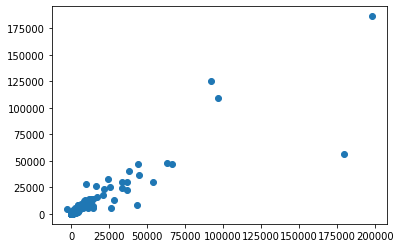

In [143]:
plt.scatter(q_dcfs_with_mc["present_cf"],q_dcfs_with_mc["Market_cap"])

## Certainly Equivalent discounted cash flow evaluation

An alternative formulation of the value of the asset is based on the *certainly equivalent cash flow*, which can be [defined](https://www.investopedia.com/terms/c/certaintyequivalent.asp) as the cash flow that one would accept now rather than accepting a higher, but uncertain, return in the future. Or, $CE(CF_{i}) = \frac{\mathbb{E}(CF_{i})}{(1+RP)}$, where $\mathbb{E}(CF_{i})$ is the cash flow as defined before and $RP$ is the risk premium, i.e. the risk-adjusted rate of return minus the risk-free rate.

The certainly equivalent discounted cash flow can be written as:

$Value(Asset) = \sum_{i}\frac{CE(CF_{i})}{(1+r_{f})^{i}}$,

where $r_f$ is the risk free rate, of the theoretical maximum return that one can obtain without any risk. 
The derivation to show that the two evaluation methods are equivalent can be found [here](http://www.normmiller.net/wp-content/uploads/2015/09/Appendix-10C.pdf) 


In [144]:
list(data.columns)

['index',
 'period',
 'freq',
 'Ticker',
 'Asset Turnover',
 'Basic EPS',
 'Basic Shares Outstanding',
 'Book Value Per Share',
 'Cash Flow From Financial Activities',
 'Cash Flow From Investing Activities',
 'Cash Flow From Operating Activities',
 'Cash On Hand',
 'Change In Accounts Payable',
 'Change In Accounts Receivable',
 'Change In Assets/Liabilities',
 'Change In Inventories',
 'Common Stock Dividends Paid',
 'Common Stock Net',
 'Comprehensive Income',
 'Cost Of Goods Sold',
 'Current Ratio',
 'Days Sales In Receivables',
 'Debt Issuance/Retirement Net - Total',
 'Debt/Equity Ratio',
 'EBIT',
 'EBIT Margin',
 'EBITDA',
 'EBITDA Margin',
 'EPS - Earnings Per Share',
 'Financial Activities - Other',
 'Free Cash Flow Per Share',
 'Goodwill And Intangible Assets',
 'Gross Margin',
 'Gross Profit',
 'Income After Taxes',
 'Income From Continuous Operations',
 'Income From Discontinued Operations',
 'Income Taxes',
 'Inventory',
 'Inventory Turnover Ratio',
 'Investing Activities -

In [147]:
list(data.columns)

['index',
 'period',
 'freq',
 'Ticker',
 'Asset Turnover',
 'Basic EPS',
 'Basic Shares Outstanding',
 'Book Value Per Share',
 'Cash Flow From Financial Activities',
 'Cash Flow From Investing Activities',
 'Cash Flow From Operating Activities',
 'Cash On Hand',
 'Change In Accounts Payable',
 'Change In Accounts Receivable',
 'Change In Assets/Liabilities',
 'Change In Inventories',
 'Common Stock Dividends Paid',
 'Common Stock Net',
 'Comprehensive Income',
 'Cost Of Goods Sold',
 'Current Ratio',
 'Days Sales In Receivables',
 'Debt Issuance/Retirement Net - Total',
 'Debt/Equity Ratio',
 'EBIT',
 'EBIT Margin',
 'EBITDA',
 'EBITDA Margin',
 'EPS - Earnings Per Share',
 'Financial Activities - Other',
 'Free Cash Flow Per Share',
 'Goodwill And Intangible Assets',
 'Gross Margin',
 'Gross Profit',
 'Income After Taxes',
 'Income From Continuous Operations',
 'Income From Discontinued Operations',
 'Income Taxes',
 'Inventory',
 'Inventory Turnover Ratio',
 'Investing Activities -

In [148]:
data['Debt/Equity Ratio']

0            NaN
1         0.3052
2         0.2972
3         0.2913
4            NaN
           ...  
449135       NaN
449136    0.0089
449137    0.0083
449138    0.0073
449139       NaN
Name: Debt/Equity Ratio, Length: 449140, dtype: float64